In [3]:
import xarray as xr
import numpy as np

import matplotlib.pylab as plt
import cartopy.crs as ccrs

import orcestra.flightplan as fp
from importlib import reload
reload(fp)
from orcestra.flightplan import LatLon, IntoCircle, bco, sal

from easygems.healpix import attach_coords, healpix_show, healpix_contour
import easygems.healpix as egh

import intake

cat = intake.open_catalog("https://tcodata.mpimet.mpg.de/internal.yaml")

In [37]:
import geopandas as gpd
import fiona
fiona.supported_drivers['LIBKML'] = 'r'

In [ ]:
file_path_ec = "../Data/preliminary_ec_tracks/Cape-Verde-ascending-ORBITs_20240810-20240911_segments_anx0.6.kml"
list_orbits = fiona.listlayers(file_path_ec)

for orbit in list_orbits:
    gdf = gpd.read_file(file_path_ec, layer=orbit)
    gdf.plot(ax=ax, facecolor='none', edgecolor='blue')

In [41]:



def find_edges(cwv, lat_cwv_max, cwv_thresh, cwv_min = 0):
    
    import scipy.signal
    
    """
    Determine latitude of peak in CWV that is closest to the latitude of peak CWV in the average CWV profile (lat_cwv_max).
    Assess where the moist tropics end by dropping all latitudes where CWV drops below cwv_min.
    Within the remaining moist band, assess the northernmost and southernmost latitude at which CWV is equal to cwv_thresh.
    
    If CWV is below cwv_thresh everywhere, return NAN values. 
    """

    if cwv.max().values <= cwv_thresh:
        lat_north, lat_south = np.nan, np.nan

    else:

        peaks_i, peaks_props = scipy.signal.find_peaks(cwv, height=cwv_thresh, prominence=2)
        
        if len(peaks_i) == 0:
            lat_north, lat_south = np.nan, np.nan

        else:
            dist_peaks = np.abs(lat_cwv_max - cwv.latitude[peaks_i])
            cwv_lat_max = dist_peaks.latitude[np.argmin(dist_peaks.values)]

            cwv_north = cwv.where((cwv.latitude >= cwv_lat_max) & (cwv > cwv_min), drop = True)
            cwv_south = cwv.where((cwv.latitude <= cwv_lat_max) & (cwv > cwv_min), drop = True)

            lat_north = float(cwv_north.latitude.where(cwv_north<=cwv_thresh).min().values)
            lat_south = float(cwv_south.latitude.where(cwv_south>=cwv_thresh).min().values)
            

    return lat_south, lat_north

In [42]:
halo_speed_12km_kmh = 225*3.6
sel_time = "2022-09-20T12:00:00"


In [43]:
ec_tracks = {'east': {'wb': -31+360.0, 'eb': -21+360.0, 'date_start': '2024-08-12'},
             'west': {'wb': -53+360.0, 'eb': -43+360.0, 'date_start': '2024-09-12'},
            }

In [44]:
band = "west"

## Worldview image and EC tracks

In [45]:
c_earth = 40075.017      # circumference of earth at equator
spd     = 86400.         # seconds per day
kpd     = c_earth/360    # kilometers per degreen longitude at the equator

t_op = 5552.7
t_cv = 5554.3

n_op = 25
n_cv =  9

def offset(n,t):
    # copmute offset in degrees for the n'th orbit
    return (-c_earth * t/86400. * n/kpd)

def calc_orbits(scenario,wb=330.,eb=340.):
 
    if (scenario == 'operations'): 
        ndays = n_op
        t = t_op
    else:
        ndays = n_cv
        t = t_cv
        scenario = 'calval'
    
    orbits = ndays * spd/t
    print (f'Calculations for {scenario}: {orbits:3g} unique orbits\n')

    lons = np.zeros(int(orbits))
    days = np.zeros(int(orbits))
    
    for i, norbit in enumerate(np.arange(0,int(orbits))):
        lons[i] = offset(norbit,t)%360
        days[i] = norbit*t/86400 + 1
    
    lons_sel =[]
    days_sel = []
    for i,lon in enumerate(lons):
        if (lon > wb and lon < eb) : 
            lons_sel.append(lons[i]-360.0);
            days_sel.append(np.round(days[i]));
            
    return lons_sel,days_sel

In [46]:
norb = 10000
i = np.arange(norb)
t = np.datetime64("2016-05-01") + i * t_op * np.timedelta64(1, "s")
o = offset(np.arange(norb), t_op) % 360
ds = xr.Dataset({
    "lon0": (("time",), o),
}, coords={
    "time": (("time",), t)
})

ds = ds.where((ds.lon0>ec_tracks[band]["wb"])&(ds.lon0<ec_tracks[band]["eb"]), drop=True).sel(time=slice('2016-08-08','2016-09-09'))
ds.time

/tmp/ipykernel_637437/2832191858.py:5: UserWarning: Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precision ahead of time.
  ds = xr.Dataset({


<xarray.DataArray 'time' (time: 14)>
array(['2016-08-09T03:05:06.000000000', '2016-08-11T02:54:00.000000000',
       '2016-08-14T03:23:37.000000000', '2016-08-16T03:12:30.000000000',
       '2016-08-18T03:01:24.000000000', '2016-08-21T03:31:01.000000000',
       '2016-08-23T03:19:55.000000000', '2016-08-25T03:08:48.000000000',
       '2016-08-27T02:57:42.000000000', '2016-08-30T03:27:19.000000000',
       '2016-09-01T03:16:13.000000000', '2016-09-03T03:05:06.000000000',
       '2016-09-05T02:54:00.000000000', '2016-09-08T03:23:37.000000000'],
      dtype='datetime64[ns]')
Coordinates:
  * time     (time) datetime64[ns] 2016-08-09T03:05:06 ... 2016-09-08T03:23:37

## Plot potential EC tracks into Worldview
show all EC tracks that cross the equator between 20°W to 30°W in August 2016

In [47]:
import pyproj

g = pyproj.Geod(ellps='WGS84')
dists = np.linspace(-3e6, 3e6, 500)

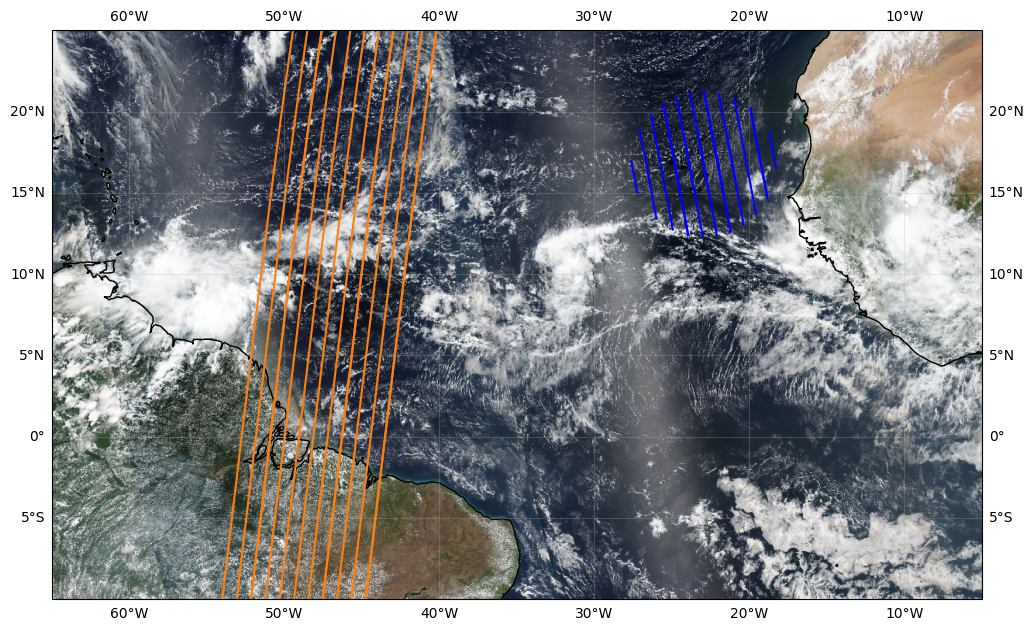

In [59]:
import requests
import cartopy.crs as ccrs
import matplotlib.pyplot as plt
from io import BytesIO

time = sel_time+"Z"
layers = "VIIRS_SNPP_CorrectedReflectance_TrueColor,Coastlines_15m" #"MODIS_Terra_CorrectedReflectance_TrueColor"
resolution = 0.05  # in degree
bbox = [-10.0, -65.0, 25.0, -5.0]  # S, E, N, W
bbox_str = ",".join([str(v) for v in bbox])
img_format = "png"
width, height = int((bbox[3] - bbox[1]) / resolution), int((bbox[2] - bbox[0]) / resolution)

url = f"https://wvs.earthdata.nasa.gov/api/v1/snapshot?REQUEST=GetSnapshot&TIME={time}&BBOX={bbox_str}&CRS=EPSG:4326&LAYERS={layers}&FORMAT=image/{img_format}&WIDTH={width}&HEIGHT={height}"
r = requests.get(url)

plt.figure(figsize = (12, 8))
ax = plt.axes(projection=ccrs.PlateCarree())
ax.set_extent([-65, -5, -10, 25], crs=ccrs.PlateCarree())
ax.coastlines(alpha=1.0)
ax.gridlines(draw_labels=True, dms=True, x_inline=False, y_inline=False, alpha = 0.25)

img = plt.imread(BytesIO(r.content))
plt.imshow(img, origin='upper', extent=[-65, -5, -10, 25], transform=ccrs.PlateCarree())

for i in range(len(ds.time)):
    lons, lats, _ = g.fwd(np.full_like(dists, ds.lon0[i]),
                      np.full_like(dists, 0),
                      np.full_like(dists, 187.1),
                      dists)
    plt.plot(lons, lats, "C1")
    

## Flight track for one EC track

Randomly select one EC track and plan the corresponding flight track

In [49]:
def find_ec_lon(lat_sel, ec_lons, ec_lats):
    return ec_lons[np.argmin(np.abs(ec_lats-lat_sel))]

In [50]:
randomtrack = 8 #np.random.randint(0, high=len(ds.time))
randomtrack

ec_lons, ec_lats, _ = g.fwd(np.full_like(dists, ds.lon0[randomtrack]),
                  np.full_like(dists, 0),
                  np.full_like(dists, 187.1),
                  dists)

In [51]:
era5 = cat.HERA5(time="P1D").to_dask().pipe(attach_coords)

In [52]:
def quickplot(path):
    map_extent = [-65, -5, -0, 20]
    fig, ax = plt.subplots(figsize=(15, 8), subplot_kw={"projection": ccrs.PlateCarree()})
    ax.set_extent(map_extent, crs=ccrs.PlateCarree())
    ax.coastlines(alpha=1.0)
    fp.plot_path(path, ax, color="C1")

In [53]:
is_ectrack = egh.isel_extent(era5, [np.min(ec_lons), np.max(ec_lons), -5, 25]) ##[W, E, S, N]

era5_region = era5.sel(
    cell=is_ectrack,
)

cwv_i = era5_region.tcwv.sel(time=sel_time).groupby(
    era5_region.latitude
).mean(
).compute(
)

lat_edge_south, lat_edge_north = find_edges(cwv_i, 8.0, 48.0, cwv_min = 42)
lat_edge_south, lat_edge_north

(8.687297821044922, 12.635624885559082)

In [54]:
radius = 100e3

airport = sal if band == "east" else bco

lat_north = np.nanmax([bco.lat, lat_edge_north+2])
north = LatLon(lat_north, find_ec_lon(lat_north, ec_lons, ec_lats), "north")

edge_north = LatLon(lat_edge_north, find_ec_lon(lat_edge_north, ec_lons, ec_lats), "edge_north")
edge_south = LatLon(lat_edge_south, find_ec_lon(lat_edge_south, ec_lons, ec_lats), "edge_south")

center = edge_north.towards(edge_south).assign_label("center")

south = LatLon(edge_south.lat-2, find_ec_lon(edge_south.lat-1, ec_lons, ec_lats), "south")

returnPoint = edge_north if band == "east" else LatLon(bco.lat, -53.0, "")


leg_south = [
     airport,
     north,
]

leg_circles = [
     north, 
     IntoCircle(edge_north, radius, 360),
     IntoCircle(center, radius, 360),
     IntoCircle(edge_south, radius, 360),
     south,
]
    
leg_home = [
     returnPoint,
     airport
]

waypoints = leg_south  + leg_circles + leg_home

path = fp.expand_path(waypoints, dx=10e3)
#print(f"duration: {halo_flight_duration(path)}")

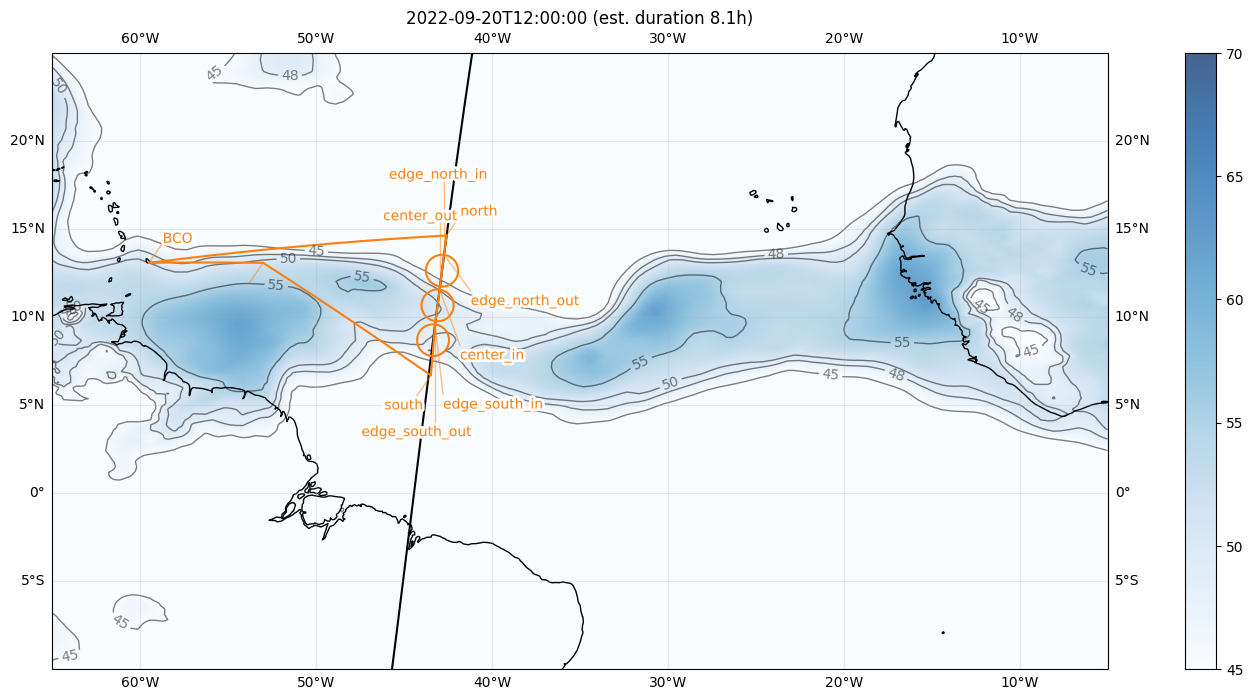

In [55]:
levels_cwv = np.sort(np.unique([45, 48, 50, 55]))

plt.figure(figsize = (20, 8))
ax = plt.axes(projection=ccrs.PlateCarree())

ax.set_extent([-65, -5, -10, 25], crs=ccrs.PlateCarree())
ax.coastlines(alpha=1.0)
ax.gridlines(draw_labels=True, dms=True, x_inline=False, y_inline=False, alpha = 0.25)

field = era5.tcwv.sel(time=sel_time)

im = healpix_show(field, method="linear",
                  alpha = 0.75, cmap = 'Blues', vmin = 45, vmax = 70)
plt.colorbar(im)

contour_lines = healpix_contour(era5.tcwv.sel(time=sel_time),
                                levels=levels_cwv, colors='k', linewidths=1, alpha = 0.5)

plt.clabel(contour_lines, inline=True, fontsize=10, colors='k', fmt='%d')

plt.plot(ec_lons, ec_lats, "k")

fp.plot_path(path, ax, color="C1")

plt.title(f"{sel_time} (est. duration {fp.track_len(path)/1e3/halo_speed_12km_kmh:.1f}h)")

plt.savefig(f"fp_{sel_time}_cwv.pdf");

In [56]:
print("Entire track: ")
print(fp.track_len(path)/1e3)
print(fp.track_len(path)/1e3/halo_speed_12km_kmh)

Entire track: 
6566.685496282393
8.10701913121283


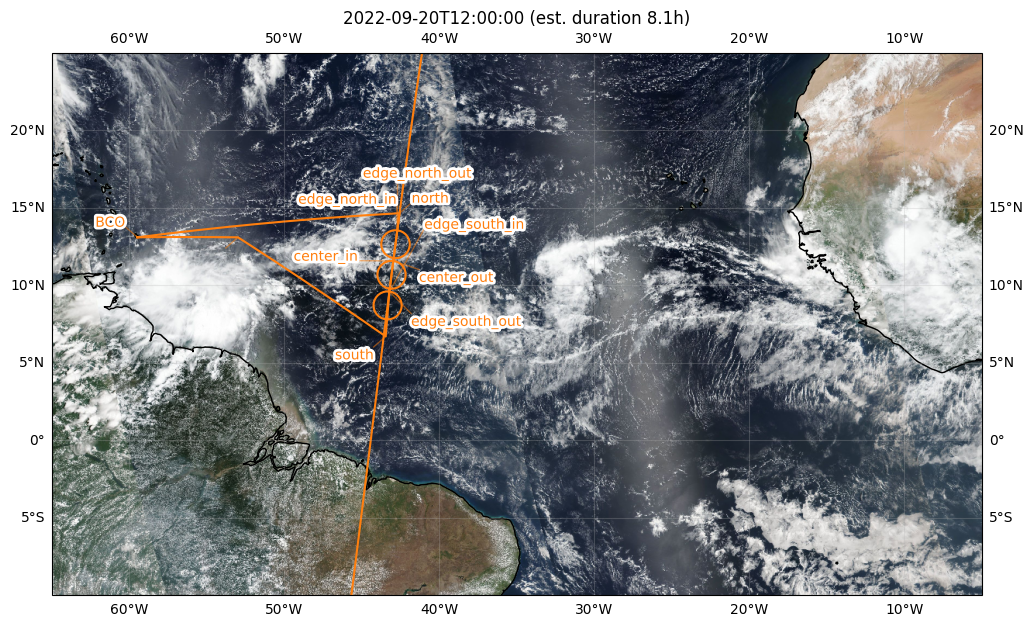

In [57]:
plt.figure(figsize = (12, 8))
ax = plt.axes(projection=ccrs.PlateCarree())
ax.set_extent([-65, -5, -10, 25], crs=ccrs.PlateCarree())
ax.coastlines(alpha=1.0)
ax.gridlines(draw_labels=True, dms=True, x_inline=False, y_inline=False, alpha = 0.25)

img = plt.imread(BytesIO(r.content))
plt.imshow(img, origin='upper', extent=[-65, -5, -10, 25], transform=ccrs.PlateCarree())


ec_lons, ec_lats, _ = g.fwd(np.full_like(dists, ds.lon0[randomtrack]),
                  np.full_like(dists, 0),
                  np.full_like(dists, 187.1),
                  dists)
plt.plot(ec_lons, ec_lats, "C1")
plt.title(f"Longitude of EC track at equator: {ds.lon0[randomtrack].values-360.0:.0f}°E")

fp.plot_path(path, ax, color="C1")

plt.title(f"{sel_time} (est. duration {fp.track_len(path)/1e3/halo_speed_12km_kmh:.1f}h)")

plt.savefig(f"fp_{sel_time}_satellite.pdf");